# Building LLMs From Scratch (Part 6): The Attention Mechanism

Welcome to Part 6! This notebook demonstrates the **attention mechanism** - the revolutionary concept that made modern LLMs possible. We'll build a simplified self-attention mechanism from scratch to understand how models learn to focus on relevant parts of the input.

### 🔗 Quick Links
- **Medium Article**: [Part 6: The Attention Mechanism](https://soloshun.medium.com/building-llms-from-scratch-part-6-the-attention-mechanism-b7ffc18c0dae)
- **GitHub Repository**: [llm-from-scratch](https://github.com/soloeinsteinmit/llm-from-scratch)

### 📋 What We'll Cover
1. **The Problem**: Why RNNs struggled with long sequences
2. **The Solution**: How attention mechanisms work
3. **Simplified Self-Attention**: Building it step by step
4. **Matrix Implementation**: Efficient computation for all tokens
5. **Visualization**: Understanding attention weights


## Setup and Imports

Let's import the necessary libraries for our attention mechanism implementation.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


✅ All imports successful!
PyTorch version: 2.5.1
Device available: CPU


## The Goal of Attention

> **The primary goal of any attention mechanism is to convert input vectors into context vectors.**

A **context vector** is an enriched version of the original input vector. It contains not just the meaning of the word itself, but also contextual information learned from its relationship with all other words in the sequence.

Let's see this in action with a concrete example.


In [2]:
# Define our input sentence and embeddings
sentence = "Your journey starts with one step"
tokens = sentence.split()

print(f"📝 Input sentence: '{sentence}'")
print(f"🔢 Tokens: {tokens}")
print(f"📊 Number of tokens: {len(tokens)}")

# Create input embeddings (these would normally come from our embedding layer)
# We'll use specific values for reproducibility and clear demonstration
inputs = torch.tensor([
    [0.43, 0.15, 0.89], # Your     (x_1)
    [0.55, 0.87, 0.66], # journey  (x_2) - our focus token
    [0.57, 0.85, 0.64], # starts   (x_3)
    [0.22, 0.58, 0.33], # with     (x_4)
    [0.77, 0.25, 0.10], # one      (x_5)
    [0.05, 0.80, 0.55], # step     (x_6)
])

print(f"\n🧠 Input embeddings shape: {inputs.shape}")
print(f"Each token is represented by a {inputs.shape[1]}-dimensional vector")
print(f"\nInput embeddings:\n{inputs}")


📝 Input sentence: 'Your journey starts with one step'
🔢 Tokens: ['Your', 'journey', 'starts', 'with', 'one', 'step']
📊 Number of tokens: 6

🧠 Input embeddings shape: torch.Size([6, 3])
Each token is represented by a 3-dimensional vector

Input embeddings:
tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])


## Step 1: Compute Attention Scores

Let's compute the context vector for our second word, "journey" (index 1). We'll start by calculating how much attention "journey" should pay to each word in the sequence, including itself.


In [3]:
# Our query is the embedding for "journey"
query_idx = 1  # "journey"
query = inputs[query_idx]

print(f"🎯 Query token: '{tokens[query_idx]}'")
print(f"🔍 Query vector: {query}")

# Step 1: Compute attention scores using dot product
# The dot product measures similarity between vectors
attn_scores_2 = torch.empty(inputs.shape[0])

print(f"\n📊 Computing attention scores for '{tokens[query_idx]}':")
print("=" * 50)

for i, x_i in enumerate(inputs):
    # Dot product between query and each input vector
    score = torch.dot(x_i, query)
    attn_scores_2[i] = score
    
    print(f"  {tokens[i]:>8} (x_{i+1}): dot_product = {score:.4f}")

print(f"\n🎯 Attention scores: {attn_scores_2}")
print(f"📈 Highest score: '{tokens[torch.argmax(attn_scores_2)]}' ({torch.max(attn_scores_2):.4f})")
print(f"📉 Lowest score:  '{tokens[torch.argmin(attn_scores_2)]}' ({torch.min(attn_scores_2):.4f})")


🎯 Query token: 'journey'
🔍 Query vector: tensor([0.5500, 0.8700, 0.6600])

📊 Computing attention scores for 'journey':
      Your (x_1): dot_product = 0.9544
   journey (x_2): dot_product = 1.4950
    starts (x_3): dot_product = 1.4754
      with (x_4): dot_product = 0.8434
       one (x_5): dot_product = 0.7070
      step (x_6): dot_product = 1.0865

🎯 Attention scores: tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
📈 Highest score: 'journey' (1.4950)
📉 Lowest score:  'one' (0.7070)


## Step 2: Normalize with Softmax

Raw attention scores can be on any scale. We need to normalize them into a probability distribution using the softmax function. This ensures all weights are between 0 and 1 and sum to 1.


In [4]:
# Step 2: Apply softmax to normalize the scores
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("🔄 Normalizing attention scores with softmax:")
print("=" * 50)

for i, (token, score, weight) in enumerate(zip(tokens, attn_scores_2, attn_weights_2)):
    print(f"  {token:>8}: {score:.4f} → {weight:.4f} ({weight*100:.1f}%)")

print(f"\n✅ Attention weights sum: {attn_weights_2.sum():.6f}")
print(f"🎯 Attention weights: {attn_weights_2}")

# The highest weights show which tokens "journey" pays most attention to
sorted_indices = torch.argsort(attn_weights_2, descending=True)
print(f"\n📊 Attention ranking for '{tokens[query_idx]}':")
for i, idx in enumerate(sorted_indices):
    print(f"  {i+1}. {tokens[idx]:>8}: {attn_weights_2[idx]:.4f} ({attn_weights_2[idx]*100:.1f}%)")


🔄 Normalizing attention scores with softmax:
      Your: 0.9544 → 0.1385 (13.9%)
   journey: 1.4950 → 0.2379 (23.8%)
    starts: 1.4754 → 0.2333 (23.3%)
      with: 0.8434 → 0.1240 (12.4%)
       one: 0.7070 → 0.1082 (10.8%)
      step: 1.0865 → 0.1581 (15.8%)

✅ Attention weights sum: 1.000000
🎯 Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

📊 Attention ranking for 'journey':
  1.  journey: 0.2379 (23.8%)
  2.   starts: 0.2333 (23.3%)
  3.     step: 0.1581 (15.8%)
  4.     Your: 0.1385 (13.9%)
  5.     with: 0.1240 (12.4%)
  6.      one: 0.1082 (10.8%)


## Step 3: Compute the Context Vector

Now we create the context vector by taking a weighted sum of all input vectors, using the attention weights we just calculated.


In [5]:
# Step 3: Compute the context vector as a weighted sum
context_vec_2 = torch.zeros(query.shape)

print("🔄 Computing context vector as weighted sum:")
print("=" * 50)

for i, (token, x_i, weight) in enumerate(zip(tokens, inputs, attn_weights_2)):
    weighted_vector = weight * x_i
    context_vec_2 += weighted_vector
    
    print(f"  {token:>8}: {weight:.4f} × {x_i} = {weighted_vector}")

print(f"\n🎯 Original 'journey' vector: {query}")
print(f"✨ Context vector for 'journey': {context_vec_2}")

# Compare the original and context vectors
print(f"\n📊 Vector comparison:")
print(f"  Original: {query}")
print(f"  Context:  {context_vec_2}")
print(f"  Difference: {context_vec_2 - query}")

# The context vector is now enriched with information from all other tokens
print(f"\n💡 The context vector contains information from:")
for i, (token, weight) in enumerate(zip(tokens, attn_weights_2)):
    if weight > 0.1:  # Only show significant contributions
        print(f"  - {token}: {weight:.1%} contribution")


🔄 Computing context vector as weighted sum:
      Your: 0.1385 × tensor([0.4300, 0.1500, 0.8900]) = tensor([0.0596, 0.0208, 0.1233])
   journey: 0.2379 × tensor([0.5500, 0.8700, 0.6600]) = tensor([0.1308, 0.2070, 0.1570])
    starts: 0.2333 × tensor([0.5700, 0.8500, 0.6400]) = tensor([0.1330, 0.1983, 0.1493])
      with: 0.1240 × tensor([0.2200, 0.5800, 0.3300]) = tensor([0.0273, 0.0719, 0.0409])
       one: 0.1082 × tensor([0.7700, 0.2500, 0.1000]) = tensor([0.0833, 0.0270, 0.0108])
      step: 0.1581 × tensor([0.0500, 0.8000, 0.5500]) = tensor([0.0079, 0.1265, 0.0870])

🎯 Original 'journey' vector: tensor([0.5500, 0.8700, 0.6600])
✨ Context vector for 'journey': tensor([0.4419, 0.6515, 0.5683])

📊 Vector comparison:
  Original: tensor([0.5500, 0.8700, 0.6600])
  Context:  tensor([0.4419, 0.6515, 0.5683])
  Difference: tensor([-0.1081, -0.2185, -0.0917])

💡 The context vector contains information from:
  - Your: 13.9% contribution
  - journey: 23.8% contribution
  - starts: 23.3% cont

## Efficient Matrix Implementation

The step-by-step approach above is great for understanding, but in practice, we use matrix operations to compute attention for all tokens simultaneously. This is much more efficient!


In [6]:
# Compute attention for ALL tokens at once using matrix operations
print("🚀 Computing attention for all tokens simultaneously:")
print("=" * 60)

# Step 1: Compute all attention scores at once
# inputs @ inputs.T computes dot product between every pair of vectors
attn_scores = inputs @ inputs.T
print(f"📊 Attention scores matrix shape: {attn_scores.shape}")
print(f"Attention scores:\n{attn_scores}")

# Step 2: Apply softmax to each row (each token's attention distribution)
attn_weights = torch.softmax(attn_scores, dim=-1)
print(f"\n🎯 Attention weights matrix shape: {attn_weights.shape}")
print(f"Attention weights:\n{attn_weights}")

# Verify our manual calculation matches the matrix version
print(f"\n✅ Verification - 'journey' attention weights:")
print(f"Manual calculation: {attn_weights_2}")
print(f"Matrix calculation: {attn_weights[1]}")
print(f"Match: {torch.allclose(attn_weights_2, attn_weights[1])}")

# Step 3: Compute all context vectors at once
all_context_vectors = attn_weights @ inputs
print(f"\n✨ All context vectors shape: {all_context_vectors.shape}")
print(f"All context vectors:\n{all_context_vectors}")

# Verify our manual context vector calculation
print(f"\n✅ Verification - 'journey' context vector:")
print(f"Manual calculation: {context_vec_2}")
print(f"Matrix calculation: {all_context_vectors[1]}")
print(f"Match: {torch.allclose(context_vec_2, all_context_vectors[1])}")


🚀 Computing attention for all tokens simultaneously:
📊 Attention scores matrix shape: torch.Size([6, 6])
Attention scores:
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

🎯 Attention weights matrix shape: torch.Size([6, 6])
Attention weights:
tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

✅ Verification - 'journey' attention weights:
Manual calculation: tensor([0.1385, 0.2379, 0.2333, 0.1240,

## Visualizing Attention Weights

Let's create a heatmap to visualize the attention patterns. This helps us understand which tokens pay attention to which other tokens.


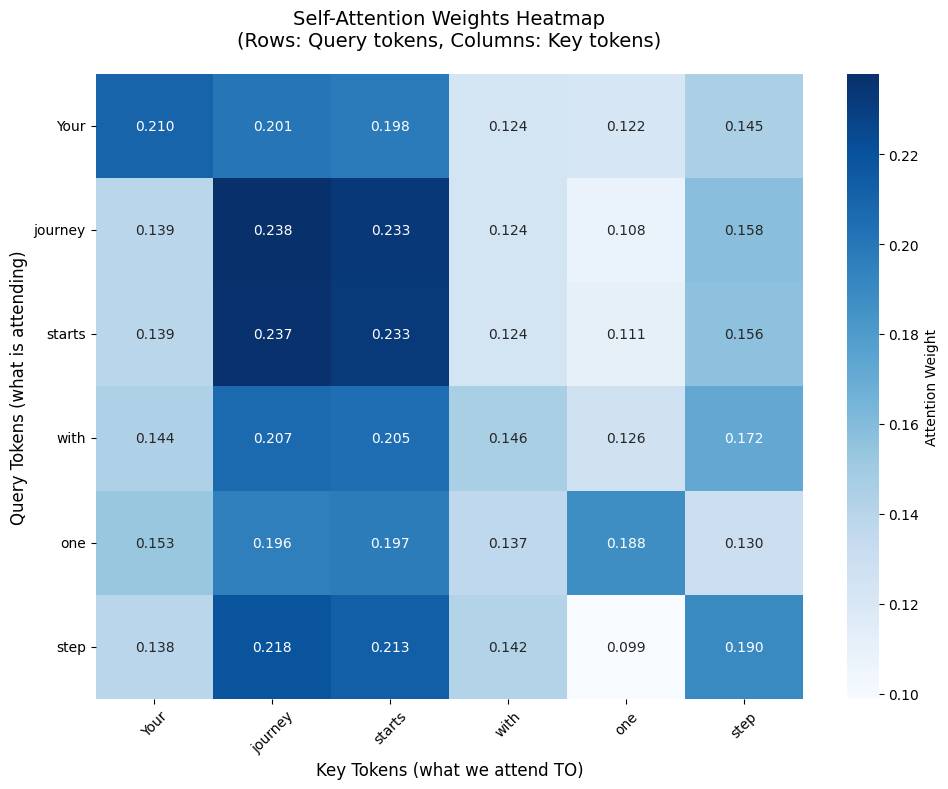

🔍 Attention Pattern Analysis:

'Your' pays most attention to:
  1. 'Your': 0.210 (21.0%)
  2. 'journey': 0.201 (20.1%)
  3. 'starts': 0.198 (19.8%)

'journey' pays most attention to:
  1. 'journey': 0.238 (23.8%)
  2. 'starts': 0.233 (23.3%)
  3. 'step': 0.158 (15.8%)

'starts' pays most attention to:
  1. 'journey': 0.237 (23.7%)
  2. 'starts': 0.233 (23.3%)
  3. 'step': 0.156 (15.6%)

'with' pays most attention to:
  1. 'journey': 0.207 (20.7%)
  2. 'starts': 0.205 (20.5%)
  3. 'step': 0.172 (17.2%)

'one' pays most attention to:
  1. 'starts': 0.197 (19.7%)
  2. 'journey': 0.196 (19.6%)
  3. 'one': 0.188 (18.8%)

'step' pays most attention to:
  1. 'journey': 0.218 (21.8%)
  2. 'starts': 0.213 (21.3%)
  3. 'step': 0.190 (19.0%)


In [7]:
# Create attention heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(
    attn_weights.numpy(), 
    annot=True, 
    fmt='.3f',
    xticklabels=tokens,
    yticklabels=tokens,
    cmap='Blues',
    cbar_kws={'label': 'Attention Weight'}
)

plt.title('Self-Attention Weights Heatmap\n(Rows: Query tokens, Columns: Key tokens)', 
          fontsize=14, pad=20)
plt.xlabel('Key Tokens (what we attend TO)', fontsize=12)
plt.ylabel('Query Tokens (what is attending)', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analyze the attention patterns
print("🔍 Attention Pattern Analysis:")
print("=" * 40)

for i, query_token in enumerate(tokens):
    # Find the token this query pays most attention to (excluding itself)
    weights = attn_weights[i]
    
    # Get top 3 attended tokens
    top_indices = torch.argsort(weights, descending=True)[:3]
    
    print(f"\n'{query_token}' pays most attention to:")
    for j, idx in enumerate(top_indices):
        print(f"  {j+1}. '{tokens[idx]}': {weights[idx]:.3f} ({weights[idx]*100:.1f}%)")


## Implementing a Simplified Self-Attention Class

Let's wrap our attention mechanism in a clean, reusable class that follows PyTorch conventions.


In [8]:
import torch.nn as nn

class SimplifiedSelfAttention(nn.Module):
    """
    A simplified self-attention mechanism without trainable weights.
    
    This implementation demonstrates the core concepts of attention:
    1. Compute attention scores (dot products)
    2. Normalize with softmax
    3. Compute weighted sum (context vectors)
    """
    
    def __init__(self, d_in, d_out=None):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out if d_out is not None else d_in
        
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_in)
            
        Returns:
            context_vectors: Output tensor of shape (batch_size, seq_len, d_out)
            attention_weights: Attention weights of shape (batch_size, seq_len, seq_len)
        """
        batch_size, seq_len, d_in = x.shape
        
        # Step 1: Compute attention scores (dot products)
        # x @ x.transpose(-2, -1) computes all pairwise dot products
        attn_scores = x @ x.transpose(-2, -1)  # (batch_size, seq_len, seq_len)
        
        # Step 2: Apply softmax normalization
        attn_weights = torch.softmax(attn_scores, dim=-1)
        
        # Step 3: Compute context vectors (weighted sum)
        context_vectors = attn_weights @ x  # (batch_size, seq_len, d_in)
        
        return context_vectors, attn_weights

# Test our class
print("🧪 Testing SimplifiedSelfAttention class:")
print("=" * 50)

# Add batch dimension to our inputs
batch_inputs = inputs.unsqueeze(0)  # Shape: (1, 6, 3)
print(f"Input shape: {batch_inputs.shape}")

# Create and test the attention layer
attention_layer = SimplifiedSelfAttention(d_in=3)
context_vecs, attn_weights_class = attention_layer(batch_inputs)

print(f"Output context vectors shape: {context_vecs.shape}")
print(f"Output attention weights shape: {attn_weights_class.shape}")

# Verify our class produces the same results
print(f"\n✅ Verification:")
print(f"Manual context vectors match class: {torch.allclose(all_context_vectors, context_vecs[0])}")
print(f"Manual attention weights match class: {torch.allclose(attn_weights, attn_weights_class[0])}")

print(f"\n🎯 Context vectors from class:\n{context_vecs[0]}")
print(f"\n🎯 Attention weights from class:\n{attn_weights_class[0]}")


🧪 Testing SimplifiedSelfAttention class:
Input shape: torch.Size([1, 6, 3])
Output context vectors shape: torch.Size([1, 6, 3])
Output attention weights shape: torch.Size([1, 6, 6])

✅ Verification:
Manual context vectors match class: True
Manual attention weights match class: True

🎯 Context vectors from class:
tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

🎯 Attention weights from class:
tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


## Comparing Original vs Context Vectors

Let's visualize how the attention mechanism transforms our input vectors into context-aware representations.


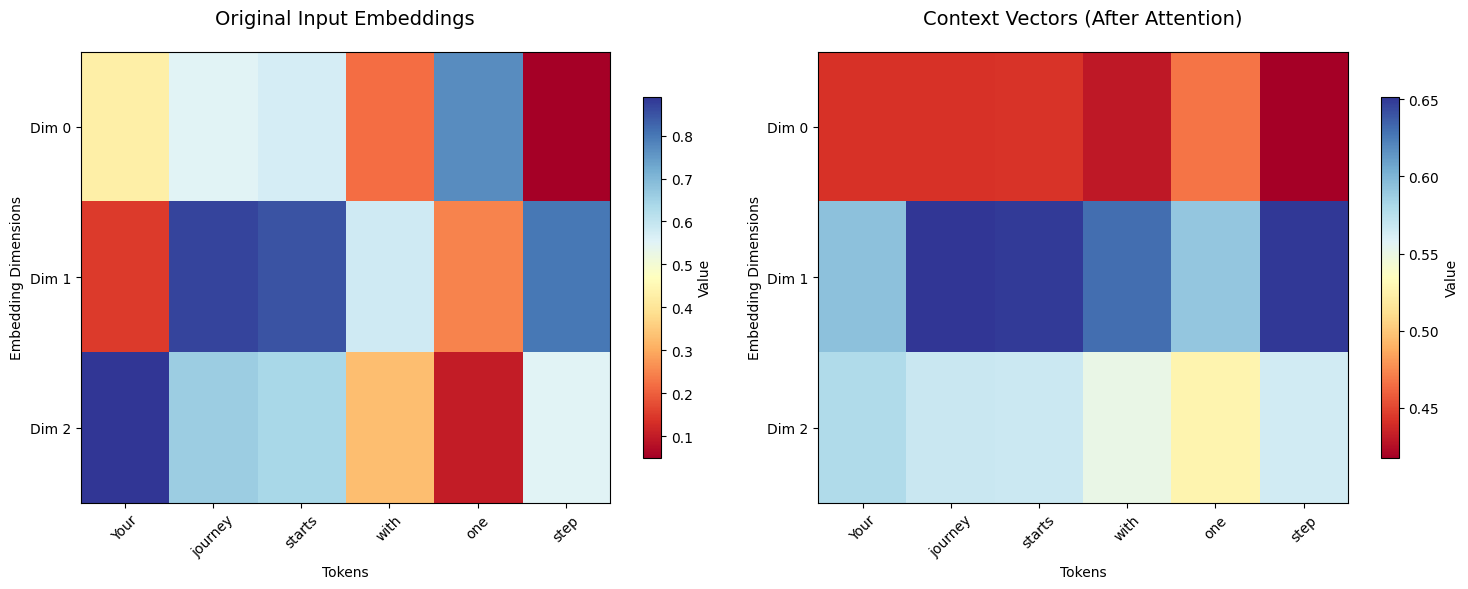

📊 Quantitative Analysis:
    Your: cos_sim=0.846, L2_dist=0.541
 journey: cos_sim=0.998, L2_dist=0.260
  starts: cos_sim=0.998, L2_dist=0.248
    with: cos_sim=0.971, L2_dist=0.309
     one: cos_sim=0.747, L2_dist=0.625
    step: cos_sim=0.915, L2_dist=0.397

💡 Interpretation:
- Cosine similarity close to 1.0 means the direction is preserved
- L2 distance shows how much the magnitude changed
- Context vectors blend information from multiple tokens


In [9]:
# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original embeddings
im1 = ax1.imshow(inputs.T.numpy(), cmap='RdYlBu', aspect='auto')
ax1.set_title('Original Input Embeddings', fontsize=14, pad=20)
ax1.set_xlabel('Tokens')
ax1.set_ylabel('Embedding Dimensions')
ax1.set_xticks(range(len(tokens)))
ax1.set_xticklabels(tokens, rotation=45)
ax1.set_yticks(range(3))
ax1.set_yticklabels(['Dim 0', 'Dim 1', 'Dim 2'])

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Value')

# Context vectors
im2 = ax2.imshow(all_context_vectors.T.numpy(), cmap='RdYlBu', aspect='auto')
ax2.set_title('Context Vectors (After Attention)', fontsize=14, pad=20)
ax2.set_xlabel('Tokens')
ax2.set_ylabel('Embedding Dimensions')
ax2.set_xticks(range(len(tokens)))
ax2.set_xticklabels(tokens, rotation=45)
ax2.set_yticks(range(3))
ax2.set_yticklabels(['Dim 0', 'Dim 1', 'Dim 2'])

# Add colorbar
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('Value')

plt.tight_layout()
plt.show()

# Quantitative comparison
print("📊 Quantitative Analysis:")
print("=" * 50)

for i, token in enumerate(tokens):
    original = inputs[i]
    context = all_context_vectors[i]
    
    # Calculate cosine similarity
    cos_sim = torch.cosine_similarity(original.unsqueeze(0), context.unsqueeze(0))
    
    # Calculate L2 distance
    l2_dist = torch.norm(original - context)
    
    print(f"{token:>8}: cos_sim={cos_sim.item():.3f}, L2_dist={l2_dist.item():.3f}")

print(f"\n💡 Interpretation:")
print(f"- Cosine similarity close to 1.0 means the direction is preserved")
print(f"- L2 distance shows how much the magnitude changed")
print(f"- Context vectors blend information from multiple tokens")


## 🎯 Summary and Key Takeaways

We've successfully implemented and understood the simplified self-attention mechanism! Let's recap what we've learned.

### What We Accomplished:
- ✅ **Understood the Goal**: Convert input vectors into context-aware vectors
- ✅ **Implemented the Three Steps**: Scoring (dot product), normalizing (softmax), weighted sum
- ✅ **Built Efficient Matrix Version**: Computed attention for all tokens simultaneously  
- ✅ **Created Reusable Class**: Clean PyTorch implementation
- ✅ **Visualized Attention Patterns**: Saw which tokens attend to which others

### The Three-Step Process:
1. **Compute Attention Scores**: Use dot products to measure similarity between tokens
2. **Normalize with Softmax**: Convert scores to probability distribution
3. **Weighted Sum**: Create context vectors by blending input vectors

### Key Insights:
- **Context vectors** contain information from the entire sequence, not just individual tokens
- **Attention weights** show which tokens are most relevant for each query token
- **Matrix operations** make the computation efficient for all tokens at once
- **No trainable parameters** yet - this is just based on input similarity

### What's Missing:
This simplified version can only compute similarity based on the initial embeddings. It can't *learn* which relationships are important for the task.

### What's Next:
In **Part 7**, we'll add **trainable weight matrices** (Query, Key, Value) to create a full self-attention mechanism that can learn optimal attention patterns during training. This is the foundation of transformer models like GPT!
